First fetch the data

In [125]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import urllib2 as url
import json

def fetch_point(x):
    y_sum = 0.0
    y_count = 0.0
    sample_next = True
    last_avg = None
    while sample_next:
        str_response = url.urlopen("http://165.227.157.145:8080/api/do_measurement?x=%f" % x).read()
        json_response = json.loads(str_response)
        if json_response.get("data", {}).get("y", None) is not None:
            y = float(json_response["data"]["y"])
            y_sum += y
            y_count += 1
            
            # sample until the average is stable
            y_avg = y_sum / y_count
            if last_avg is not None:
                diff = last_avg - y_avg
                rel_diff = (abs(diff) / abs(y_avg))
                sample_next = rel_diff > 0.01
            last_avg = y_avg
        else:
            sample_next = False
            
            
    return y_sum / y_count if y_count > 0 else None

def fetch_data(x_from, x_to, x_step):
    data_x = []
    data_y = []
    for x in np.arange(x_from, x_to + x_step, x_step):
        y = fetch_point(x)
        if y is not None:
            data_x.append(x)
            data_y.append(y)
        
    return np.asarray(data_x), np.asarray(data_y)
        
    
x_from, x_to = -10, 10
x_step = 0.5      
        
data_x, data_y = fetch_data(-10, 10, 0.5)
validation_data_x, validation_data_y = fetch_data(-50, 50, 1)

Plot the data around zero and also the full data

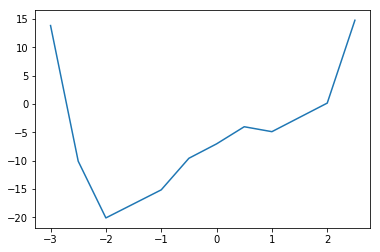

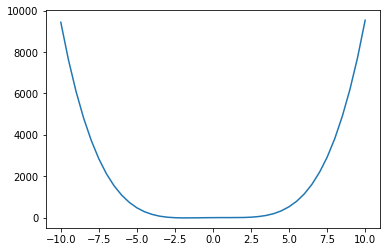

In [163]:
plt.figure()
half = len(data_x) / 2
plt.plot(data_x[half - 5:half + 5], data_y[half - 5:half + 5])
plt.show()

plt.figure()
plt.plot(data_x, data_y)
plt.show()

Fit higher and higher order polynomials, stop when adding higher orders brings no more benefits.

In [164]:
order = 1
data_variance = np.var(data_y)
while True:
    p_opt, residuals, _, _, _ = np.polyfit(data_x, data_y, order, full=True)
    r2 = 1 - np.sum(residuals ** 2) / data_variance
    if p_opt[0] < 1e-3 and r2 > 0.9:
        order -= 1
        break
    order += 1

print "Found a fitting polynomial of order " + str(order)
p_opt = np.polyfit(data_x, data_y, order)

Found a fitting polynomial of order 4


Plot the found polynomial and the original data to visually verify the fit on the **validation data**.

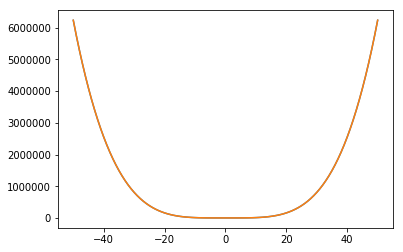

In [172]:
def plot_validate_polynomial(p_coeffs):
    pred_y = np.polyval(p_coeffs, validation_data_x)

    plt.figure()
    plt.plot(validation_data_x, pred_y)
    plt.plot(validation_data_x, validation_data_y)
    plt.show()
    
plot_validate_polynomial(p_opt)

Pretty print the found polynomial

In [173]:
def format_p(p_coeffs):
    return " + ".join([str(p) + "x^" + str(len(p_coeffs) - i - 1) for i, p in enumerate(p_coeffs)])

print format_p(p_opt)

0.999811676289x^4 + -0.000742171224826x^3 + -4.9677808173x^2 + 5.09418460056x^1 + -6.36492253574x^0


Round the coefficients to integers as the higher orders are almost integers and lower coefficients do not change the fot too much and can be explained by noise. Integers just look pretty.

In [175]:
p_integer  = np.round(p_opt)
print format_p(p_integer)

1.0x^4 + -0.0x^3 + -5.0x^2 + 5.0x^1 + -6.0x^0


Validate again that the fit is still ok

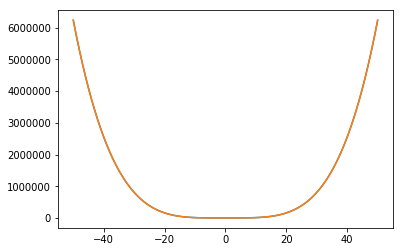

In [176]:
plot_validate_polynomial(p_integer)